In [27]:
import os
import shutil
from datetime import datetime
from gc import collect as garbage_collect
from warnings import warn
import wandb
import copy

import torch
import yaml
from datasets import load_dataset
from dotenv import load_dotenv
from roboflow import Roboflow
from torch.cuda import empty_cache as cuda_empty_cache
from torch.cuda import mem_get_info
from ultralytics import YOLO
from wandb.integration.ultralytics import add_wandb_callback
from general_config import Config

ImportError: cannot import name 'YOLOv10' from 'ultralytics' (/home/camilo/Repositorios/ultralytics/ultralytics/__init__.py)

## **Load the Models**

In [15]:
original_model_name = "yolov9c"
new_model_architecture = "yolov9c-2xhead.yaml"

original_model_path = os.path.join(Config.ORIGINAL_MODELS_DIR, original_model_name + ".pt")
trained_state_dict_path = os.path.join(Config.FINAL_MODELS_DIR, f"{original_model_name}_lp.pth")
trained_architecture_path = os.path.join(Config.CONFIGS_DIR, new_model_architecture)

original_model = YOLO(original_model_path)
trained_model = YOLO(trained_architecture_path, task="detect").load(original_model_path)

3
torch.Size([1, 144, 32, 32])
3
torch.Size([1, 65, 32, 32])
3
torch.Size([1, 144, 32, 32])
3
torch.Size([1, 65, 32, 32])
Transferred 937/1022 items from pretrained weights


In [16]:
# Keep a copy of old state dict for sanity check
old_dict = copy.deepcopy(original_model.state_dict())

# We should freeze all but the last layer
# Print the keys of the state dictionary
print(list(original_model.state_dict().keys()))

# torch.Size([1, 144, 32, 32])
# 3
# torch.Size([1, 65, 32, 32])

['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv1.conv.weight', 'model.model.2.cv2.0.cv1.bn.weight', 'model.model.2.cv2.0.cv1.bn.bias', 'model.model.2.cv2.0.cv1.bn.running_mean', 'model.model.2.cv2.0.cv1.bn.running_var', 'model.model.2.cv2.0.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv2.conv.weight', 'model.model.2.cv2.0.cv2.bn.weight', 'model.model.2.cv2.0.cv2.bn.bias', 'model.model.2.cv2.0.cv2.bn.running_mean', 'model.model.2.cv

## **Add New `ConcatHead` Layer**

In [17]:
trained_model.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv1.conv.weight', 'model.model.2.cv2.0.cv1.bn.weight', 'model.model.2.cv2.0.cv1.bn.bias', 'model.model.2.cv2.0.cv1.bn.running_mean', 'model.model.2.cv2.0.cv1.bn.running_var', 'model.model.2.cv2.0.cv1.bn.num_batches_tracked', 'model.model.2.cv2.0.cv2.conv.weight', 'model.model.2.cv2.0.cv2.bn.weight', 'model.model.2.cv2.0.cv2.bn.bias', 'model.model.2.cv2.0.cv2.bn.running_mean', 'model

In [18]:
trained_state_dict = torch.load(trained_state_dict_path)
trained_state_dict.keys()

dict_keys(['model.model.23.cv2.0.0.conv.weight', 'model.model.23.cv2.0.0.bn.weight', 'model.model.23.cv2.0.0.bn.bias', 'model.model.23.cv2.0.0.bn.running_mean', 'model.model.23.cv2.0.0.bn.running_var', 'model.model.23.cv2.0.0.bn.num_batches_tracked', 'model.model.23.cv2.0.1.conv.weight', 'model.model.23.cv2.0.1.bn.weight', 'model.model.23.cv2.0.1.bn.bias', 'model.model.23.cv2.0.1.bn.running_mean', 'model.model.23.cv2.0.1.bn.running_var', 'model.model.23.cv2.0.1.bn.num_batches_tracked', 'model.model.23.cv2.0.2.weight', 'model.model.23.cv2.0.2.bias', 'model.model.23.cv2.1.0.conv.weight', 'model.model.23.cv2.1.0.bn.weight', 'model.model.23.cv2.1.0.bn.bias', 'model.model.23.cv2.1.0.bn.running_mean', 'model.model.23.cv2.1.0.bn.running_var', 'model.model.23.cv2.1.0.bn.num_batches_tracked', 'model.model.23.cv2.1.1.conv.weight', 'model.model.23.cv2.1.1.bn.weight', 'model.model.23.cv2.1.1.bn.bias', 'model.model.23.cv2.1.1.bn.running_mean', 'model.model.23.cv2.1.1.bn.running_var', 'model.model.2

In [19]:
# Load state_dict of the custom trained model head. Layer 23.
trained_model.load_state_dict(trained_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv2.0.cv1.conv.weight', 'model.model.2.cv2.0.cv1.bn.weight', 'model.model.2.cv2.0.cv1.bn.bias', 'model.model.2.cv2.0.cv1.bn.running_mean', 'model.model.2.cv2.0.cv1.bn.running_var', 'model.model.2.cv2.0.cv2.conv.weight', 'model.model.2.cv2.0.cv2.bn.weight', 'model.model.2.cv2.0.cv2.bn.bias', 'model.model.2.cv2.0.cv2.bn.running_mean', 'model.model.2.cv2.0.cv2.bn.running_var', 'model.model.2.cv2.0.cv3.conv.weight', 'model.model.2.cv2.0.cv3.bn.weight', 'model.model.2.cv2.0.cv3.bn.bias', 'model.

In [20]:
# Get the keys that are not present in the original model
new_keys = set(trained_model.names.keys()) - set(original_model.names.keys())
old_model_names = trained_model.names.copy()

# Redefine the names dictionary
trained_model.model.names = original_model.names
for k in new_keys:
    trained_model.model.names[k] = old_model_names[k]

trained_model.model.names[80] = "fretboard"
print(trained_model.model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [21]:
# Save .pt of merged model
trained_model.ckpt = {"model": trained_model.model}
trained_model.save(
    os.path.join(Config.FINAL_MODELS_DIR, f"{original_model_name}_trained_with_head.pt")
)

## **Test**

In [22]:
# Output of COCO model
result_original = original_model.predict(os.path.join(Config.IMAGES_DIR, "test-coco.jpg"))[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-coco.jpg: 480x640 3 persons, 1 bus, 1 traffic light, 85.1ms
Speed: 1.3ms preprocess, 85.1ms inference, 38.2ms postprocess per image at shape (1, 3, 480, 640)


In [23]:
# Output of custom model
result_custom_model = trained_model.predict(os.path.join(Config.IMAGES_DIR, "test-coco.jpg"))[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-coco.jpg: 480x640 3 persons, 1 bus, 1 traffic light, 19.4ms
Speed: 0.6ms preprocess, 19.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


In [24]:
# Output of the new model
result_custom_model_2 = trained_model.predict(os.path.join(Config.IMAGES_DIR, "test-fretboard.jpg"))[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-fretboard.jpg: 384x640 1 person, 1 fretboard, 60.2ms
Speed: 0.6ms preprocess, 60.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


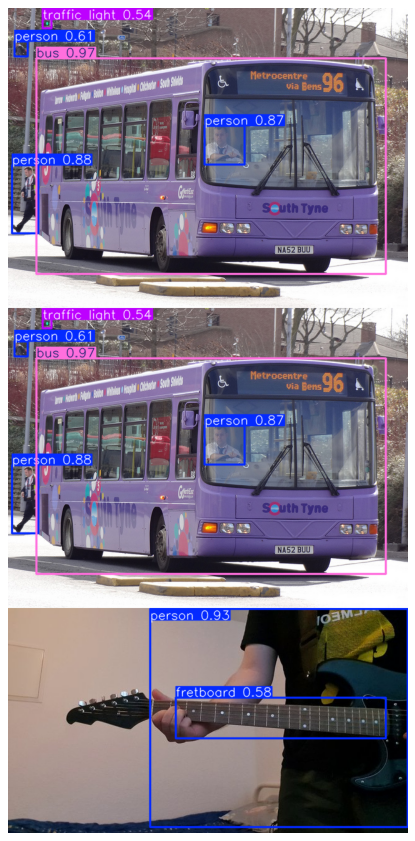

In [25]:
import matplotlib.pyplot as plt
import numpy as np


def show_output(images, name="output", dpi=80, savefig=False):
    image = np.vstack(images)
    fig = plt.figure(dpi=dpi)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    fig.set_size_inches((5, 15))
    ax.imshow(image[..., ::-1])
    fig.tight_layout()

    # If name already exists, add an index to the name
    name = f"{name}.jpg"
    i = 1
    while os.path.exists(os.path.join(Config.IMAGES_DIR, name)):
        name = name[:-4]
        name = f"{name}_{i}.jpg"
        i += 1
    if savefig:
        name_path = os.path.join(Config.IMAGES_DIR, name)
        plt.savefig(
            os.path.join(Config.IMAGES_DIR, name_path),
            bbox_inches="tight",
            pad_inches=0.05,
            dpi=dpi,
        )
    plt.show()
    plt.close()


show_output([result_original.plot(), result_custom_model.plot(), result_custom_model_2.plot()])

image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/data/guitar-necks-detector/valid/images/00bd37ba0766e253cc82e587b9d1aee2_jpg.rf.d004201156494166fc5d249b393d4aaa.jpg: 640x640 1 person, 1 remote, 1 fretboard, 21.6ms
Speed: 0.8ms preprocess, 21.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/data/guitar-necks-detector/valid/images/00bd37ba0766e253cc82e587b9d1aee2_jpg.rf.d004201156494166fc5d249b393d4aaa.jpg: 640x640 1 fretboard, 15.7ms
Speed: 0.8ms preprocess, 15.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/data/guitar-necks-detector/valid/images/00bd37ba0766e253cc82e587b9d1aee2_jpg.rf.d004201156494166fc5d249b393d4aaa.jpg: 640x640 1 person, 1 remote, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


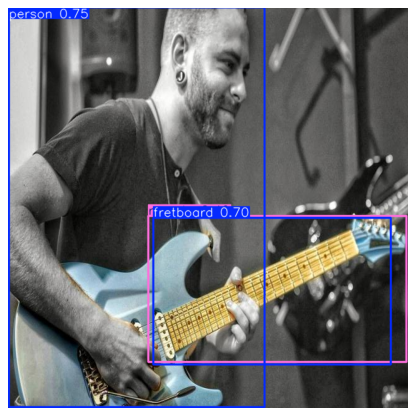

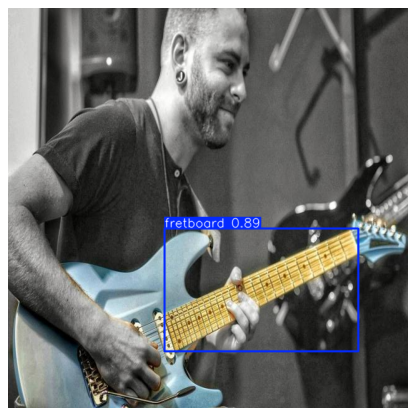

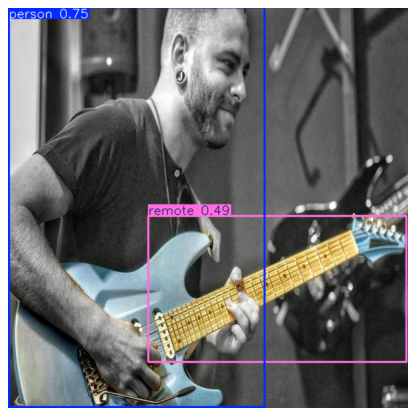

In [26]:
# Another test
non_frozen_model = YOLO(
    os.path.join(Config.FINAL_MODELS_DIR, f"{original_model_name}_trained_without_freezing.pt")
)
non_frozen_model.model.names[0] = "fretboard"

image_path = os.path.join(
    Config.DATA_DIR,
    "guitar-necks-detector",
    "valid",
    "images",
    "00bd37ba0766e253cc82e587b9d1aee2_jpg.rf.d004201156494166fc5d249b393d4aaa.jpg",
)

conf = 0.36
our_result = trained_model.predict(image_path, conf=conf)[0]
non_frozen_result = non_frozen_model.predict(image_path, conf=conf)[0]
orig_result = original_model.predict(image_path, conf=conf)[0]
show_output([our_result.plot()], name="other-image-finetuned")
show_output([non_frozen_result.plot()], name="other-image-non-frozen")
show_output([orig_result.plot()], name="other-image-original")